# Generative Flow Network Demo
From https://colab.research.google.com/drive/1fUMwgu2OhYpQagpzU5mhe9_Esib3Q2VR


In [1]:
import matplotlib.pyplot as matplotlib_pyplot
import numpy as numpy
import torch
from torch.distributions.categorical import Categorical
import tqdm
import sys
import os

# Add the project root directory to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

import gflownet as gflownet

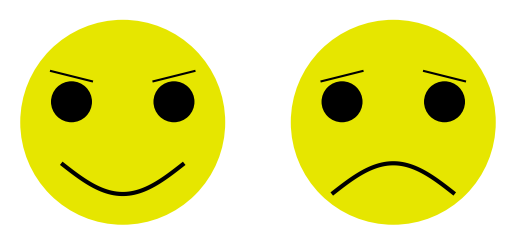

In [2]:
f, ax = matplotlib_pyplot.subplots(1,2)
matplotlib_pyplot.sca(ax[0])
smiling_face = gflownet.Face(['smile', 'left_eb_down', 'right_eb_down'])
frowning_face = gflownet.Face(['frown', 'left_eb_up', 'right_eb_up'])
gflownet.Face.draw_face(smiling_face)
matplotlib_pyplot.sca(ax[1])
gflownet.Face.draw_face(frowning_face)

In [3]:
enumerated_states, transitions = gflownet.Face.enumerate_states_transitions(gflownet.Face.sorted_keys)
unique_states = []
for face in enumerated_states:
    if set(face.patches) not in [set(u.patches) for u in unique_states]:
        unique_states.append(face)

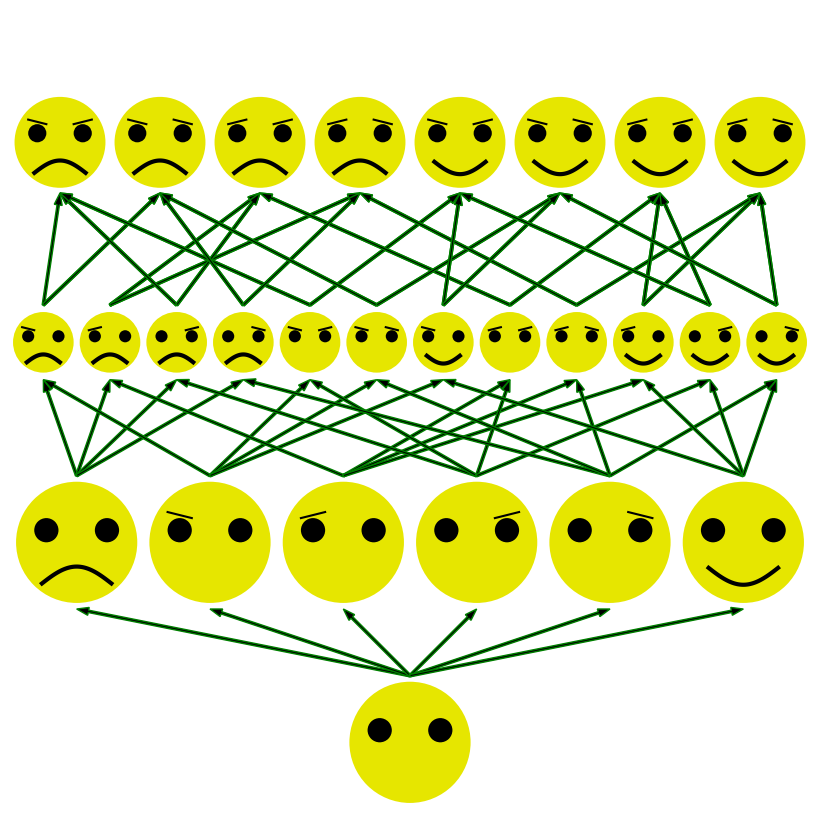

In [4]:
def face_hash(face):
  return tuple([i in face for i in gflownet.Face.sorted_keys])
lens = [len([i for i in unique_states if len(i) == j]) for j in range(4)]
levels = [sorted([i for i in unique_states if len(i) == j]) for j in range(4)]
f = matplotlib_pyplot.figure(figsize=(8, 8))
face2pos = {}
for i, (level, L) in enumerate(zip(levels, lens)):
  for j, face in enumerate(level):
    ax = f.add_axes([j/L, i/4, 1/L, 1/6])
    face.draw_face()
    face2pos[face_hash(face)] = (j/L+0.5/L, i/4)
ax = f.add_axes([0,0,1,1])
matplotlib_pyplot.sca(ax)
matplotlib_pyplot.gca().set_facecolor((0,0,0,0))
matplotlib_pyplot.xlim(0,1)
matplotlib_pyplot.ylim(0,1)
for a, b in transitions[1:]:
  pa, pb = face2pos[face_hash(a)], face2pos[face_hash(b)]
  if not len(b): continue
  lb = int(pb[1] * 4)
  la = int(pa[1] * 4)
  ws = [1/6,1/6,0.13,0.11]
  matplotlib_pyplot.arrow(pa[0],pa[1]+ws[la],pb[0]-pa[0],pb[1]-pa[1]-ws[lb], head_width=0.01, width=0.003, ec=(0.,0.5,0),fc=(0,0,0),
           length_includes_head=True)
  matplotlib_pyplot.axis('off')

In [5]:
# We first define how the model will view a face, i.e. how to encode a face in
# a tensor
def face_to_tensor(face):
  return torch.tensor([i in face for i in gflownet.Face.sorted_keys]).float()
  
def face_parents(state):
  parent_states = []  # states that are parents of state
  parent_actions = []  # actions that lead from those parents to state
  for face_part in state:
    # For each face part, there is a parent without that part
    parent_states.append([i for i in state if i != face_part])
    # The action to get there is the corresponding index of that face part
    parent_actions.append(gflownet.Face.sorted_keys.index(face_part))
  return parent_states, parent_actions

In [6]:
# Instantiate model and optimizer
F_sa = gflownet.FlowModel(512)
opt = torch.optim.Adam(F_sa.parameters(), 3e-4)

# Let's keep track of the losses and the faces we sample
losses = []
sampled_faces = []
# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0
update_freq = 4
for episode in tqdm.tqdm(range(50000), ncols=40):
  # Each episode starts with an "empty state"
  state = []
  # Predict F(s, a)
  edge_flow_prediction = F_sa(face_to_tensor(state))
  for t in range(3):
    # The policy is just normalizing, and gives us the probability of each action
    policy = edge_flow_prediction / edge_flow_prediction.sum()
    # Sample the action
    action = Categorical(probs=policy).sample()
    # "Go" to the next state
    new_state = state + [gflownet.Face.sorted_keys[action]]

    # Now we want to compute the loss, we'll first enumerate the parents
    parent_states, parent_actions = face_parents(new_state)
    # And compute the edge flows F(s, a) of each parent
    px = torch.stack([face_to_tensor(p) for p in parent_states])
    pa = torch.tensor(parent_actions).long()
    parent_edge_flow_preds = F_sa(px)[torch.arange(len(parent_states)), pa]
    # Now we need to compute the reward and F(s, a) of the current state,
    # which is currently `new_state`
    if t == 2:
      # If we've built a complete face, we're done, so the reward is > 0
      # (unless the face is invalid)
      reward = gflownet.Face(new_state).face_reward()
      # and since there are no children to this state F(s,a) = 0 \forall a
      edge_flow_prediction = torch.zeros(6)
    else:
      # Otherwise we keep going, and compute F(s, a)
      reward = 0
      edge_flow_prediction = F_sa(face_to_tensor(new_state))

    # The loss as per the equation above
    flow_mismatch = (parent_edge_flow_preds.sum() - edge_flow_prediction.sum() - reward).pow(2)
    minibatch_loss += flow_mismatch  # Accumulate
    # Continue iterating
    state = new_state

  # We're done with the episode, add the face to the list, and if we are at an
  # update episode, take a gradient step.
  sampled_faces.append(state)
  if episode % update_freq == 0:
    losses.append(minibatch_loss.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0

100%|█| 50000/50000 [00:32<00:00, 1561.2


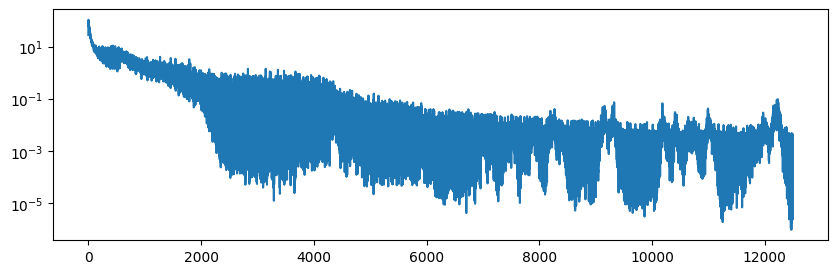

In [7]:
matplotlib_pyplot.figure(figsize=(10,3))
matplotlib_pyplot.plot(losses)
matplotlib_pyplot.yscale('log')

Ratio of faces with a smile: 0.59375
Ratio of valid faces: 0.9140625


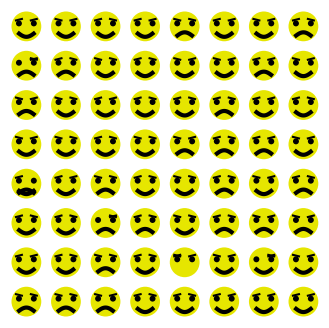

In [8]:
f, ax = matplotlib_pyplot.subplots(8,8,figsize=(4,4))
print('Ratio of faces with a smile:', sum(['smile' in i for i in sampled_faces[-128:]]) / 128)
print('Ratio of valid faces:', sum([gflownet.Face(i).face_reward() > 0 for i in sampled_faces[-128:]]) / 128)
for i, face in enumerate(sampled_faces[-64:]):
  matplotlib_pyplot.sca(ax[i//8,i%8])
  gflownet.Face(face).draw_face()

In [9]:
#@title
import matplotlib.cm as cm
lens = [len([i for i in enumerated_states if len(i) == j]) for j in range(4)]
levels = [sorted([i for i in enumerated_states if len(i) == j]) for j in range(4)]
f = pp.figure(figsize=(8, 8))
def face_hash(face):
  return tuple([i in face for i in sorted_keys])
face2pos = {}
for i, (level, L) in enumerate(zip(levels, lens)):
  for j, face in enumerate(level):
    ax = f.add_axes([j/L, i/4, 1/L, 1/6])
    draw_face(face)
    face2pos[face_hash(face)] = (j/L+0.5/L, i/4)
    Fstate = F_sa(torch.tensor(face_hash(face)).float())
    #print(face, Fstate.data)
ax = f.add_axes([0,0,1,1])
pp.sca(ax)
pp.gca().set_facecolor((0,0,0,0))
pp.xlim(0,1)
pp.ylim(0,1)
for a, b in transitions[1:]:
  if not len(b):
    continue
  pa, pb = face2pos[face_hash(a)], face2pos[face_hash(b)]
  lb = int(pb[1] * 4)
  Fstate = F_sa(torch.tensor(face_hash(a)).float())
  Fa = Fstate[sorted_keys.index([i for i in b if i not in a][0])].item()
  c = cm.brg(Fa/3)
  lb = int(pb[1] * 4)
  la = int(pa[1] * 4)
  ws = [1/6,1/6,0.13,0.11]
  pp.arrow(pa[0],pa[1]+ws[la],pb[0]-pa[0],pb[1]-pa[1]-ws[lb], head_width=0.01, width=0.003, ec=c,fc=c,
           length_includes_head=True)
  pp.axis('off')
ax = f.add_axes([1, 0.2, 0.05, 0.6])
pp.sca(ax)
f.colorbar(cm.ScalarMappable(norm=cm.colors.Normalize(vmin=0, vmax=3), cmap=cm.brg), cax=ax, label='Edge Flow');


NameError: name 'pp' is not defined

In [17]:
F_sa(face_to_tensor([])).sum()

tensor(12.7090, grad_fn=<SumBackward0>)